In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [ ]:
import torch
from torchvision.datasets import FashionMNIST
import torchvision
from torchvision import transforms

train_set = FashionMNIST("./data", download=True, train=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

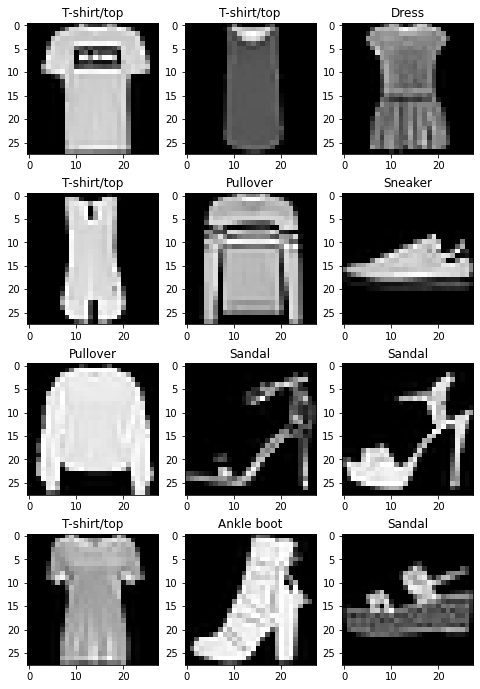

In [ ]:
fig = plt.figure(figsize=(8, 12))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    img, label = train_set[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_set.classes[label])

In [ ]:
train_set.data.size(), len(train_set.classes)
# 60000 чб картинок размером 28*28, 10 классов одежды

(torch.Size([60000, 28, 28]), 10)

In [ ]:
# все это из документации

class NeuralNetwork(nn.Module):
    def __init__(self, in_features=28*28*1, out_features=10):
        super(NeuralNetwork, self).__init__()
        #  initialize the nn.Flatten layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        x = self.flatten(x)  # n_channels * width * height
        logits = self.linear_relu_stack(x)
        return logits


# шаг пакетного обучения
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    losses = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        losses += loss
        avg_loss = losses / num_batches
    return avg_loss 


# оценка модели на тестовой выборке (акьюраси и ошибка)
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Обучаем модель

In [ ]:
# все еще из документации
learning_rate = 1e-3
batch_size = 64
epochs = 5

model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=len(test_set))

losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.309151  [    0/60000]
loss: 2.288607  [ 6400/60000]
loss: 2.275041  [12800/60000]
loss: 2.268036  [19200/60000]
loss: 2.257895  [25600/60000]
loss: 2.252251  [32000/60000]
loss: 2.246078  [38400/60000]
loss: 2.224840  [44800/60000]
loss: 2.212698  [51200/60000]
loss: 2.193624  [57600/60000]
Test Error: 
 Accuracy: 43.9%, Avg loss: 2.180875 

Epoch 2
-------------------------------
loss: 2.193968  [    0/60000]
loss: 2.173797  [ 6400/60000]
loss: 2.129926  [12800/60000]
loss: 2.139228  [19200/60000]
loss: 2.098517  [25600/60000]
loss: 2.068336  [32000/60000]
loss: 2.080847  [38400/60000]
loss: 2.017279  [44800/60000]
loss: 2.004558  [51200/60000]
loss: 1.960388  [57600/60000]
Test Error: 
 Accuracy: 55.1%, Avg loss: 1.942446 

Epoch 3
-------------------------------
loss: 1.972304  [    0/60000]
loss: 1.938096  [ 6400/60000]
loss: 1.835197  [12800/60000]
loss: 1.867353  [19200/60000]
loss: 1.777857  [25600/60000]
loss: 1.740701  [32000/600

График ошибок по эпохам

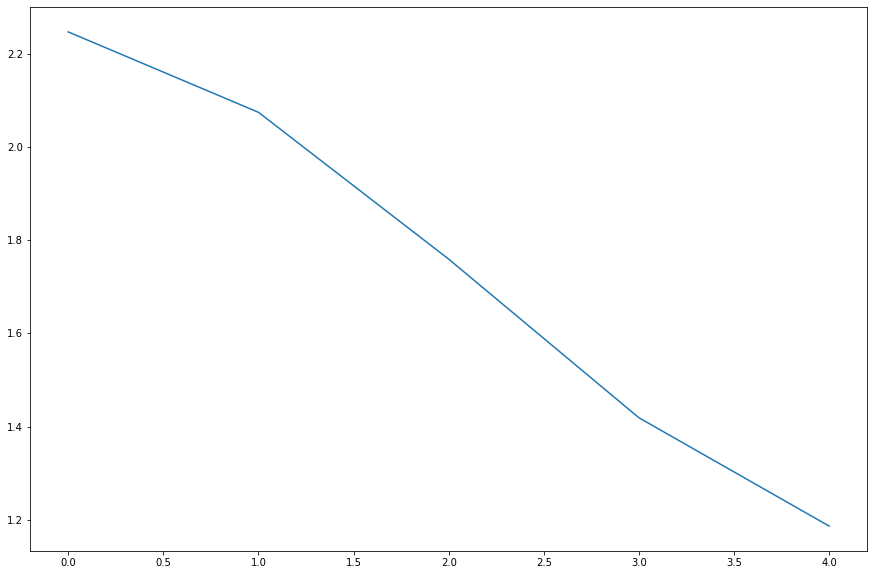

In [ ]:
with torch.no_grad():
  plt.plot(losses)

Тестируем на тестовой выборке

In [ ]:
img, label = test_set[1]
model(img), model(img).argmax(), label

(tensor([[ 0.4150, -3.2191,  3.2446, -1.4445,  2.7689, -1.9510,  2.3061, -3.2803,
           1.0885, -1.4299]], grad_fn=<AddmmBackward0>), tensor(2), 2)

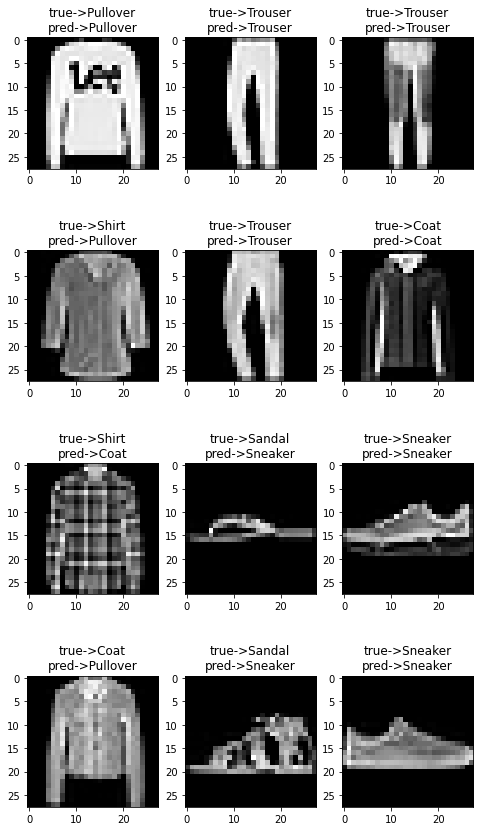

In [ ]:
fig = plt.figure(figsize=(8, 15))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    #sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_set[i]
    pred_label = model(img).argmax()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f'true->{train_set.classes[true_label]}\npred->{train_set.classes[pred_label]}')

Матрица ошибок

In [ ]:
from sklearn.metrics import confusion_matrix

X_test, y_true = next(iter(test_dataloader))
y_pred = model(X_test).argmax(dim=1)

cm = confusion_matrix(y_true, y_pred)

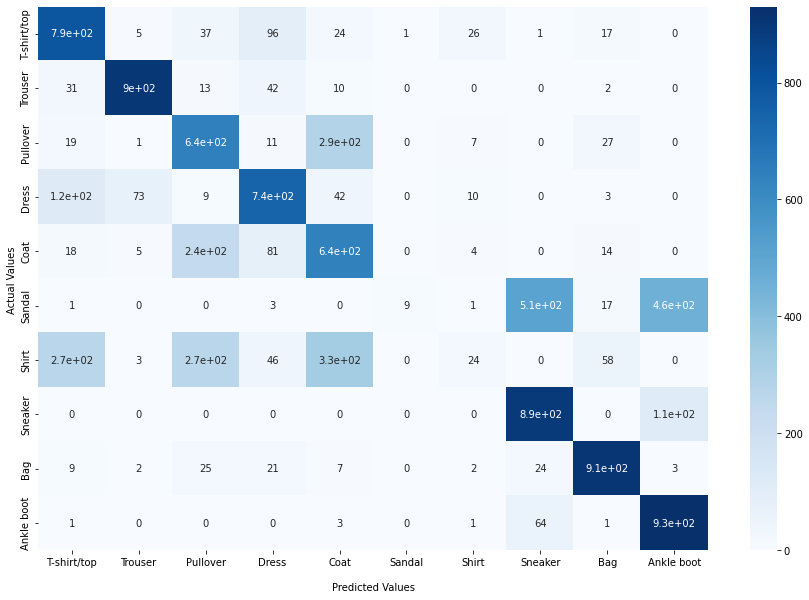

In [ ]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 10)

ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(test_set.classes)
ax.yaxis.set_ticklabels(test_set.classes)

plt.show()

Accuracy

In [ ]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 64.8%, Avg loss: 1.111387 



Сохраняем модель

In [ ]:
torch.save(model, 'model_FashionMNIST.pth')

In [ ]:
model = torch.load('model_FashionMNIST.pth')
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [ ]:
class ConvNet(nn.Module): 
  def __init__(self, in_channels=1, n_classes=10): # 1 - потому что чб
       super(ConvNet, self).__init__() 
       self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1), 
          nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
       # после этого 32 канала и изображения размером 14х14 (было 28х28)
       self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
           nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
       # после этого 64 канала и изображения размером 7х7
       self.drop_out = nn.Dropout() # отсеивающий слой для предотвращения переобучения модели
       self.fc1 = nn.Linear(7 * 7 * 64, 1000) # теперь создаем полносвязный слой
       self.fc2 = nn.Linear(1000, n_classes)
  def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) # разглаживает размеры данных с nхnхm до (n*n*m)х1
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out
  def forward_1l(self, x): 
        out = self.layer1(x) 
        return out

  # размер измерения = (размер измерения - размер ядра + 2*паддинга) / шаг + 1

In [ ]:
learning_rate = 1e-3
batch_size = 100
epochs = 5

model = ConvNet()
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=len(test_set))

losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.306511  [    0/60000]
loss: 0.467894  [10000/60000]
loss: 0.360586  [20000/60000]
loss: 0.519200  [30000/60000]
loss: 0.504656  [40000/60000]
loss: 0.518002  [50000/60000]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.396700 

Epoch 2
-------------------------------
loss: 0.243194  [    0/60000]
loss: 0.401134  [10000/60000]
loss: 0.336417  [20000/60000]
loss: 0.381883  [30000/60000]
loss: 0.435848  [40000/60000]
loss: 0.384524  [50000/60000]
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.354882 

Epoch 3
-------------------------------
loss: 0.202580  [    0/60000]
loss: 0.300521  [10000/60000]
loss: 0.297089  [20000/60000]
loss: 0.327900  [30000/60000]
loss: 0.402271  [40000/60000]
loss: 0.418136  [50000/60000]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.329386 

Epoch 4
-------------------------------
loss: 0.156863  [    0/60000]
loss: 0.260652  [10000/60000]
loss: 0.293187  [20000/60000]
loss: 0.299465  [30000/60000]
loss: 0.364948  [40000/6

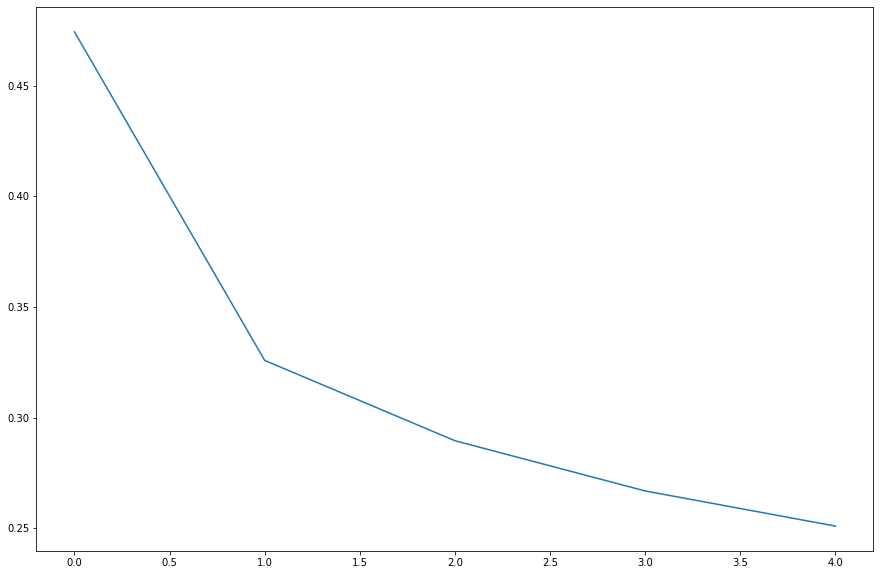

In [ ]:
with torch.no_grad():
  plt.plot(losses)

In [ ]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 89.1%, Avg loss: 0.303162 



In [ ]:
from sklearn.metrics import confusion_matrix

X_test, y_true = next(iter(test_dataloader))
y_pred = model(X_test).argmax(dim=1)

cm = confusion_matrix(y_true, y_pred)

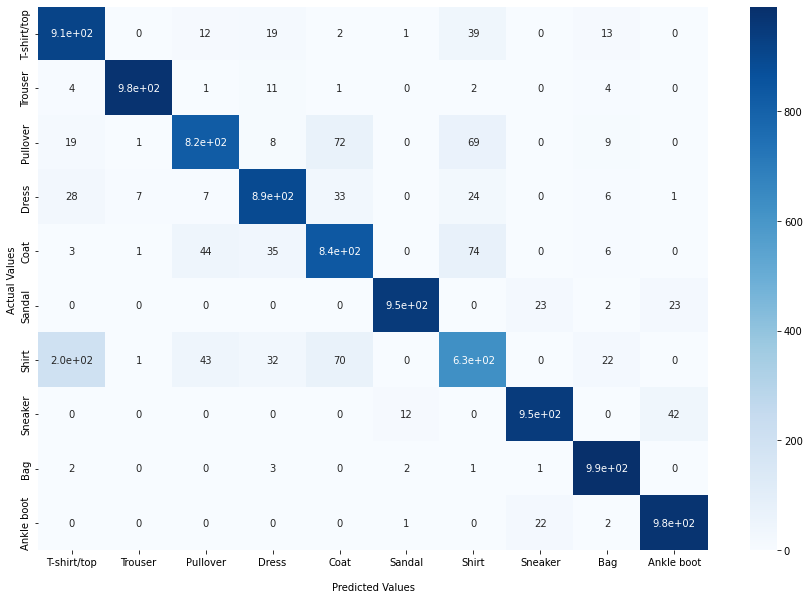

In [ ]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 10)

ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(test_set.classes)
ax.yaxis.set_ticklabels(test_set.classes)

plt.show()

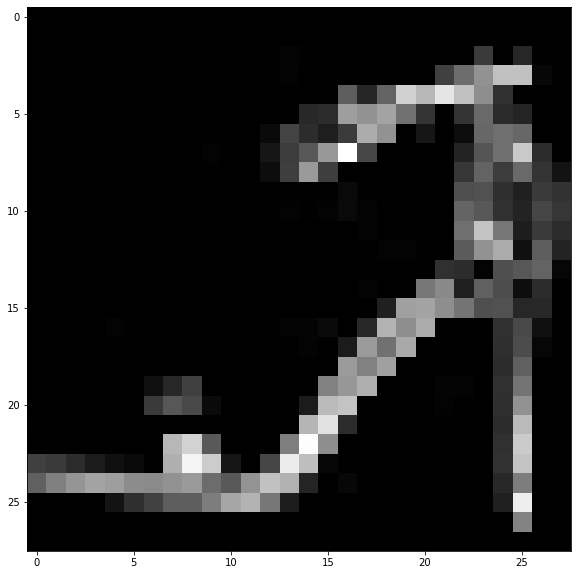

In [ ]:
# до свертки
img, target = train_set[8]
plt.imshow(img.squeeze(), cmap="gray")

In [ ]:
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

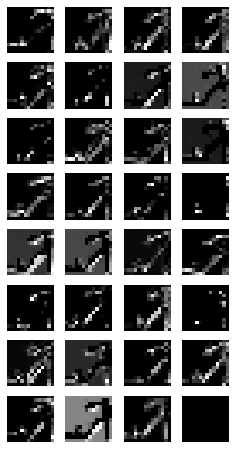

In [ ]:
# изображения после 1 слоя свертки
first_conv_layer = model.layer1
fig, axes = plt.subplots(8, 4, figsize=(4, 8))  
for channel, ax in zip(first_conv_layer(img), axes.flatten()):
    ax.axis("off")
    ax.imshow(channel.detach(), cmap="gray")

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

***Все абсолютно аналогично 1.1, наверно поэтому такая плохая модель***

In [ ]:
from torchvision.datasets import CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),  
])

train_set = CIFAR10("./data", download=True, train=True, transform=transform)
test_set = CIFAR10("./data", download=True, train=False, transform=transform)  

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


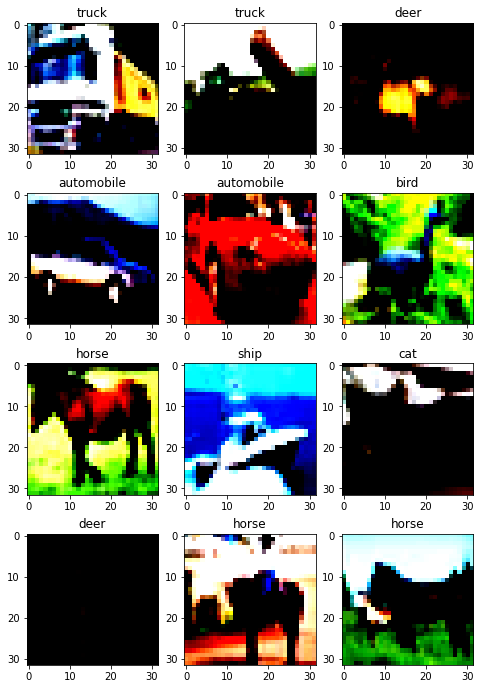

In [ ]:
fig = plt.figure(figsize=(8, 12))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    img, label = train_set[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(train_set.classes[label])

In [ ]:
train_set.data.shape, len(train_set.classes)
# 50000 картинок размером 32*32, цветные, 10 классов 

((50000, 32, 32, 3), 10)

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

model = NeuralNetwork(in_features=32*32*3, out_features=10)
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=len(test_set))

losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.294823  [    0/50000]
loss: 1.774078  [ 6400/50000]
loss: 1.415802  [12800/50000]
loss: 1.785266  [19200/50000]
loss: 1.741016  [25600/50000]
loss: 1.723937  [32000/50000]
loss: 1.659840  [38400/50000]
loss: 1.577078  [44800/50000]
Test Error: 
 Accuracy: 46.3%, Avg loss: 1.528270 

Epoch 2
-------------------------------
loss: 1.522663  [    0/50000]
loss: 1.530224  [ 6400/50000]
loss: 1.153172  [12800/50000]
loss: 1.620076  [19200/50000]
loss: 1.518878  [25600/50000]
loss: 1.554736  [32000/50000]
loss: 1.591233  [38400/50000]
loss: 1.443284  [44800/50000]
Test Error: 
 Accuracy: 48.3%, Avg loss: 1.476479 

Epoch 3
-------------------------------
loss: 1.472256  [    0/50000]
loss: 1.469566  [ 6400/50000]
loss: 1.016169  [12800/50000]
loss: 1.507869  [19200/50000]
loss: 1.330400  [25600/50000]
loss: 1.404883  [32000/50000]
loss: 1.383073  [38400/50000]
loss: 1.398535  [44800/50000]
Test Error: 
 Accuracy: 49.6%, Avg loss: 1.478615 

Epoc

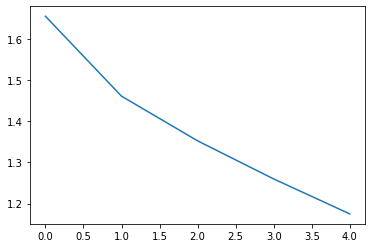

In [ ]:
with torch.no_grad():
  plt.plot(losses)

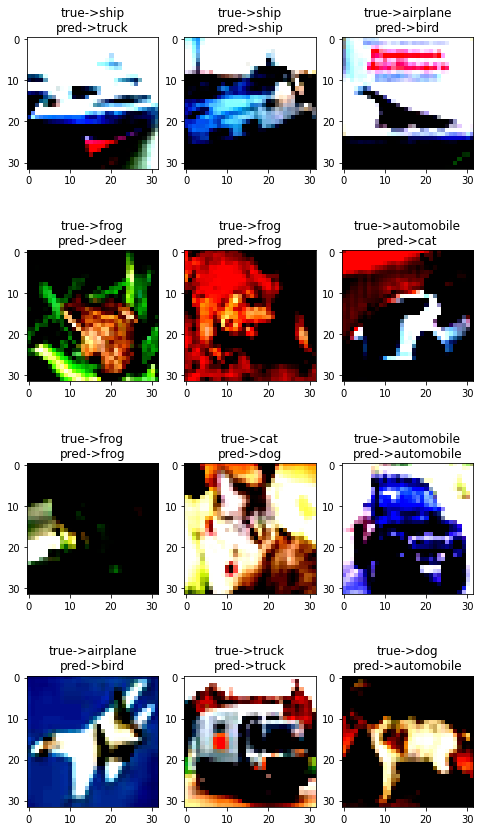

In [ ]:
fig = plt.figure(figsize=(8, 15))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    #sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_set[i]
    pred_label = model(img.unsqueeze(0)).argmax()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'true->{train_set.classes[true_label]}\npred->{train_set.classes[pred_label]}')

In [ ]:
from sklearn.metrics import confusion_matrix

X_test, y_true = next(iter(test_dataloader))
y_pred = model(X_test).argmax(dim=1)

cm = confusion_matrix(y_true, y_pred)

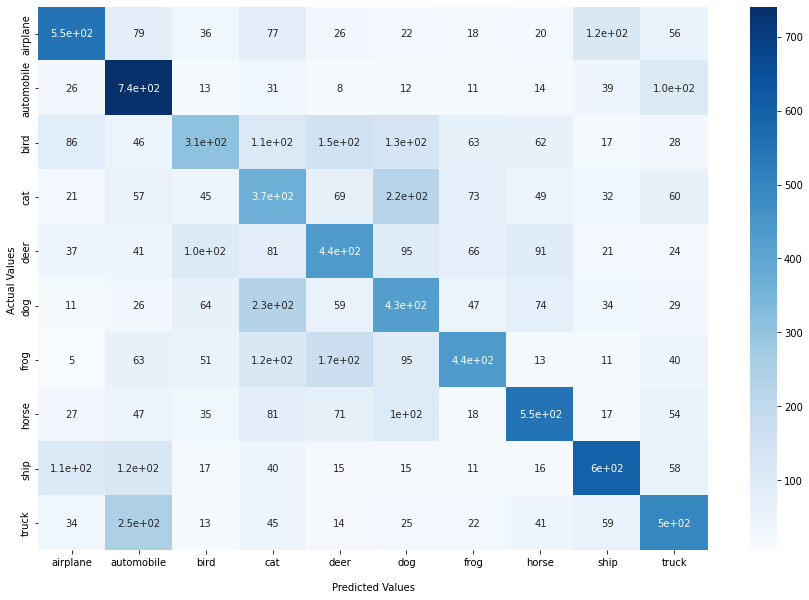

In [ ]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 10)

ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(test_set.classes)
ax.yaxis.set_ticklabels(test_set.classes)

plt.show()

In [ ]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 49.2%, Avg loss: 1.553845 



In [ ]:
torch.save(model, 'model_CIFAR10.pth')

model = torch.load('model_CIFAR10.pth')
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

***Аналагично 1.2, опять же поэтому наверно все оч плохо***

In [ ]:
class ConvNet(nn.Module): 
  def __init__(self, in_channels=3, n_classes=10): # 3 - потому что ргб
       super(ConvNet, self).__init__() 
       self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1), 
          nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
       # после этого 32 канала и изображения размером 16х16 (было 32х32)
       self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
           nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
       # после этого 64 канала и изображения размером 8х8
       self.drop_out = nn.Dropout() # отсеивающий слой для предотвращения переобучения модели
       self.fc1 = nn.Linear(8 * 8 * 64, 512) # теперь создаем полносвязный слой
       self.fc2 = nn.Linear(512, 128)
       self.fc3 = nn.Linear(128, n_classes)
  def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) # разглаживает размеры данных с nхnхm до (n*n*m)х1
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        out = self.fc3(out) 
        return out
  def forward_1l(self, x): 
        out = self.layer1(x) 
        return out

  # размер измерения = (размер измерения - размер ядра + 2*паддинга) / шаг + 1

In [ ]:
learning_rate = 1e-3
batch_size = 128
epochs = 10

model = ConvNet()
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=len(test_set))

losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.307280  [    0/50000]
loss: 1.659238  [12800/50000]
loss: 1.567076  [25600/50000]
loss: 1.439435  [38400/50000]
Test Error: 
 Accuracy: 48.8%, Avg loss: 1.410160 

Epoch 2
-------------------------------
loss: 1.404359  [    0/50000]
loss: 1.353190  [12800/50000]
loss: 1.422811  [25600/50000]
loss: 1.286565  [38400/50000]
Test Error: 
 Accuracy: 54.5%, Avg loss: 1.289610 

Epoch 3
-------------------------------
loss: 1.249032  [    0/50000]
loss: 1.275916  [12800/50000]
loss: 1.261831  [25600/50000]
loss: 1.193483  [38400/50000]
Test Error: 
 Accuracy: 58.6%, Avg loss: 1.192960 

Epoch 4
-------------------------------
loss: 1.091554  [    0/50000]
loss: 1.206726  [12800/50000]
loss: 1.058962  [25600/50000]
loss: 1.188919  [38400/50000]
Test Error: 
 Accuracy: 61.9%, Avg loss: 1.112672 

Epoch 5
-------------------------------
loss: 0.959924  [    0/50000]
loss: 0.972775  [12800/50000]
loss: 1.019518  [25600/50000]
loss: 1.066431  [38400

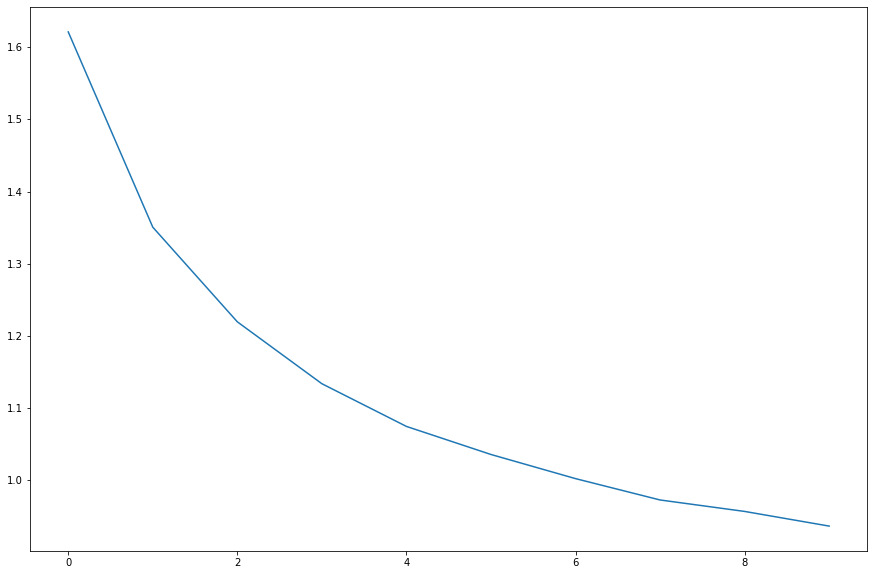

In [ ]:
with torch.no_grad():
  plt.plot(losses)

In [ ]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 65.4%, Avg loss: 1.002417 



не 70 но лучше чем 49 :)

In [ ]:
from sklearn.metrics import confusion_matrix

X_test, y_true = next(iter(test_dataloader))
y_pred = model(X_test).argmax(dim=1)

cm = confusion_matrix(y_true, y_pred)

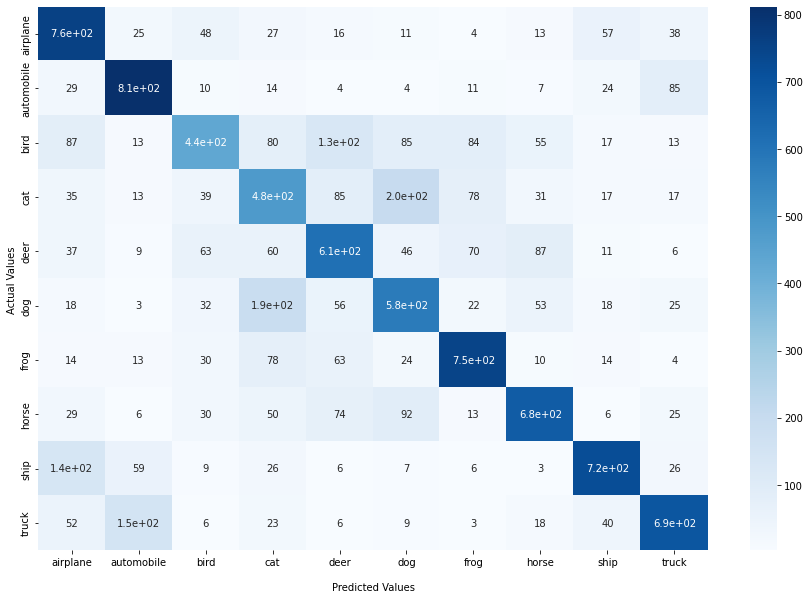

In [ ]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 10)

ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(test_set.classes)
ax.yaxis.set_ticklabels(test_set.classes)

plt.show()

In [ ]:
img.size(), img.permute(1, 2, 0).size()

(torch.Size([3, 32, 32]), torch.Size([32, 32, 3]))

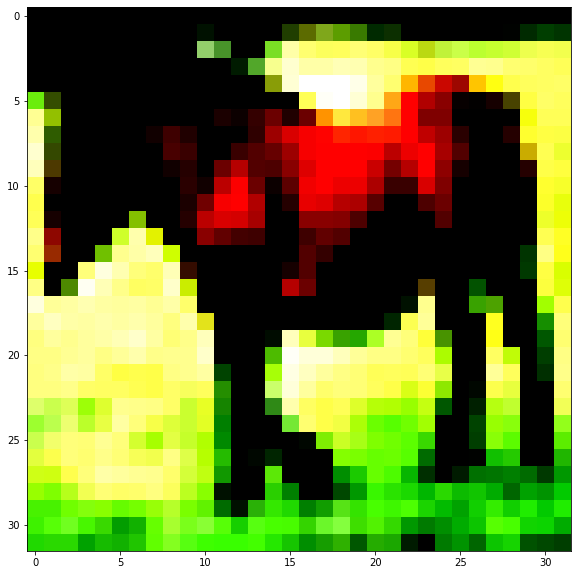

In [ ]:
# до свертки
img, target = train_set[7]
plt.imshow(img.permute(1, 2, 0))

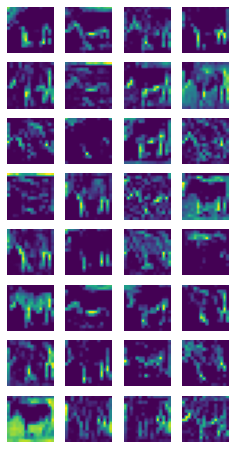

In [ ]:
# изображения после 1 слоя свертки
first_conv_layer = model.layer1
fig, axes = plt.subplots(8, 4, figsize=(4, 8))  
for channel, ax in zip(first_conv_layer(img), axes.flatten()):
    ax.axis("off")
    ax.imshow(channel.detach())

## 3. Загрузка изображений из внешних источников

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('/content/gdrive/MyDrive/Colab Notebooks/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:11<00:00, 115.80it/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(400, 400)), 
    transforms.ToTensor()
    ])

train_monkeys_dataset = datasets.ImageFolder(
    "/content/gdrive/MyDrive/Colab Notebooks/monkeys/training/training",
    transform=transform)

test_monkeys_dataset = datasets.ImageFolder(
    "/content/gdrive/MyDrive/Colab Notebooks/monkeys/validation/validation",
    transform=transform) 
            

In [ ]:
train_monkeys_dataset

Dataset ImageFolder
    Number of datapoints: 1097
    Root location: /content/gdrive/MyDrive/Colab Notebooks/monkeys/training/training
    StandardTransform
Transform: Compose(
               Resize(size=(400, 400), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [ ]:
print(f'''кол-во картинок в тренировочной выборке -> {len(train_monkeys_dataset)}
кол-во картинок в тестовой выборке -> {len(test_monkeys_dataset)}
размер картинок -> {train_monkeys_dataset[0][0].size()}
классы -> {train_monkeys_dataset.classes}''')

кол-во картинок в тренировочной выборке -> 1097
кол-во картинок в тестовой выборке -> 272
размер картинок -> torch.Size([3, 400, 400])
классы -> ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [ ]:
class ConvNet(nn.Module): 
  def __init__(self, in_channels=3, n_classes=10): # 3 - потому что ргб
       super(ConvNet, self).__init__() 
       self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1), 
          nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
       self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
           nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
       self.drop_out = nn.Dropout() # отсеивающий слой для предотвращения переобучения модели
       self.fc1 = nn.Linear(100 * 100 * 64, 512) # теперь создаем полносвязный слой
       self.fc2 = nn.Linear(512, 128)
       self.fc3 = nn.Linear(128, n_classes)
  def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) # разглаживает размеры данных с nхnхm до (n*n*m)х1
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        out = self.fc3(out) 
        return out
  def forward_1l(self, x): 
        out = self.layer1(x) 
        return out

In [ ]:
learning_rate = 0.1
batch_size = 8
epochs = 10

model = ConvNet()
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_monkeys_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_monkeys_dataset, batch_size=len(test_monkeys_dataset))

losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")


Epoch 1
-------------------------------
loss: 2.320220  [    0/ 1097]


KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
  plt.plot(losses)

In [ ]:
test_loop(test_dataloader, model, loss_fn)

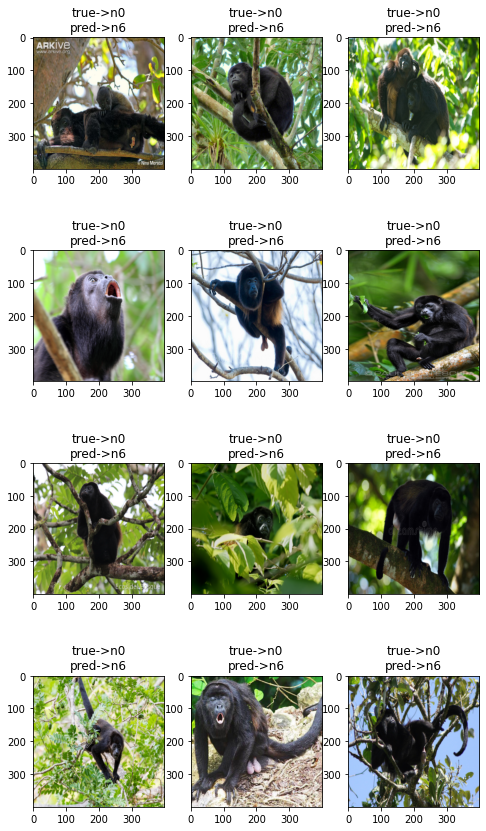

In [ ]:
fig = plt.figure(figsize=(8, 15))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    #sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_monkeys_dataset[i]
    pred_label = model(img.unsqueeze(0)).argmax(1)
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'true->{test_monkeys_dataset.classes[true_label]}\npred->{test_monkeys_dataset.classes[pred_label]}')


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test, y_true = next(iter(test_dataloader))
y_pred = model(X_test).argmax(dim=1)

cm = confusion_matrix(y_true, y_pred)

plt.rcParams["figure.figsize"] = (15, 10)

ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(test_monkeys_dataset.classes)
ax.yaxis.set_ticklabels(test_monkeys_dataset.classes)

plt.show()


In [ ]:
torch.save(model, 'model_monkeys.pth')

model = torch.load('model_monkeys.pth')
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=640000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(400, 400)),
    transforms.ToTensor(),
])


cats_dogs_dataset = datasets.ImageFolder(
    "/content/gdrive/MyDrive/Colab Notebooks/cats_dogs/cats_dogs/train",
    transform=transform
)

train_size = round(0.8 * len(cats_dogs_dataset))
train_cats_dogs_dataset, test_cats_dogs_dataset = random_split(
    cats_dogs_dataset,
    lengths=(train_size, len(cats_dogs_dataset) - train_size),
)

In [ ]:
print(f'''кол-во картинок в тренировочной выборке -> {len(train_cats_dogs_dataset)}
кол-во картинок в тестовой выборке -> {len(test_cats_dogs_dataset)}
размер картинок -> {train_cats_dogs_dataset[0][0].size()}
классы -> {train_cats_dogs_dataset.classes}''')

кол-во картинок в тренировочной выборке -> 1097
кол-во картинок в тестовой выборке -> 272
размер картинок -> torch.Size([3, 400, 400])
классы -> ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [ ]:
learning_rate = 0.1
batch_size = 8
epochs = 10

model = ConvNet()
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_cats_dogs_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_cats_dogs_dataset, batch_size=len(test_cats_dogs_dataset))

losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")


In [ ]:
with torch.no_grad():
  plt.plot(losses)

In [ ]:
test_loop(test_dataloader, model, loss_fn)

In [ ]:
fig = plt.figure(figsize=(8, 15))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    #sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_cats_dogs_dataset[i]
    pred_label = model(img.unsqueeze(0)).argmax(1)
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'true->{test_cats_dogs_dataset.classes[true_label]}\npred->{test_cats_dogs_dataset.classes[pred_label]}')


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test, y_true = next(iter(test_dataloader))
y_pred = model(X_test).argmax(dim=1)

cm = confusion_matrix(y_true, y_pred)

plt.rcParams["figure.figsize"] = (15, 10)

ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(test_cats_dogs_dataset.classes)
ax.yaxis.set_ticklabels(test_cats_dogs_dataset.classes)

plt.show()


# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

train_monkeys_dataset = datasets.ImageFolder(
    "/content/gdrive/MyDrive/Colab Notebooks/monkeys/training/training",
    transform=transform
)

test_monkeys_dataset = datasets.ImageFolder(
    "/content/gdrive/MyDrive/Colab Notebooks/monkeys/validation/validation",
   transform=transform
)

print(f'''кол-во картинок в тренировочной выборке -> {len(train_monkeys_dataset)}
кол-во картинок в тестовой выборке -> {len(test_monkeys_dataset)}
размер картинок -> {train_monkeys_dataset[0][0].size()}
классы -> {train_monkeys_dataset.classes}''')


кол-во картинок в тренировочной выборке -> 1097
кол-во картинок в тестовой выборке -> 272
размер картинок -> torch.Size([3, 224, 224])
классы -> ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [ ]:
from torchvision.models import vgg16, VGG16_Weights

class MonkeysVGG16(nn.Module):

    def __init__(self):
        super(MonkeysVGG16, self).__init__()
        self.vgg16 = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.vgg16.classifier[-1] = nn.Linear(self.vgg16.classifier[-1].in_features, 10)

    def forward(self, x):
        return self.vgg16(x)

In [ ]:
learning_rate = 1e-3
batch_size = 8
epochs = 5

model = MonkeysVGG16()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_monkeys_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_monkeys_dataset, batch_size=len(test_monkeys_dataset))

model 

MonkeysVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (

In [ ]:
losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")


Epoch 1
-------------------------------
loss: 3.026298  [    0/ 1097]


KeyboardInterrupt: ignored

In [ ]:
test_loop(test_dataloader, model, loss_fn)

In [ ]:
# дообучение классификатора

for p in model.vgg16.features.parameters():
    p.requires_grad = False  # замороженные слои не участвуют в расчете градиента

# оптимизатор не будет обновлять параметры замороженных слоев
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)

In [ ]:
test_loop(test_dataloader, model, loss_fn)

### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(400, 400)),
    transforms.ToTensor(),
])


cats_dogs_dataset = datasets.ImageFolder(
    "/content/gdrive/MyDrive/Colab Notebooks/cats_dogs/cats_dogs/train",
    transform=transform
)

train_size = round(0.8 * len(cats_dogs_dataset))
train_cats_dogs_dataset, test_cats_dogs_dataset = random_split(
    cats_dogs_dataset,
    lengths=(train_size, len(cats_dogs_dataset) - train_size),
)


print(f'''кол-во картинок в тренировочной выборке -> {len(train_cats_dogs_dataset)}
кол-во картинок в тестовой выборке -> {len(test_cats_dogs_dataset)}
размер картинок -> {train_cats_dogs_dataset[0][0].size()}
классы -> {train_cats_dogs_dataset.classes}''')

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

class CatsDogsResnet18(nn.Module):

    def __init__(self):
        super(CatsDogsResnet18, self).__init__()
        self.resnet18 = resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, 2)

    def forward(self, x):
        return self.resnet34(x)

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

model = CatsDogsResnet18()
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train_dataloader = DataLoader(train_cats_dogs_dataset, batch_size=batch_size)
# test_dataloader = DataLoader(test_cats_dogs_dataset, batch_size=len(test_cats_dogs_dataset))

model 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

CatsDogsResnet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
test_loop(test_dataloader, model, loss_fn)

In [ ]:
# дообучение классификатора

for p in model.parameters():
    p.requires_grad = False

for p in model.resnet18.fc.parameters():
    p.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)

In [ ]:
test_loop(test_dataloader, model, loss_fn)